# Predicting Forest Fires Area in Portugual

In this project we will be working with meteorological data from the UCI machine learning repository. We aim to understand how the burned area of forest fires, in the northeast region of Portugal, is related to the meteorological and other data. We will apply different ML methods to predict the burned area using 12 different features - such as month, wind, rain and other more specific metheorological terms.


## Data Exploration
Our first step will be to explore the variables and perform data manipulation techniques, if necessary, in order to prepare the dataset for secondary steps such as appllying Machine Learning methods. The dataset contains `spatial`, `temporal`, `technical` indexes (from the Canadian system for rating fire danger) and `meteorological` data. We will import different librarys and load the dataset to have a first look - and in sequence the features will be described with details that were provided by the source of the dataset.

In [49]:
library(ggplot2)
library(MASS)
library(data.table)
library(grid)
library(gridExtra)
library(lattice)
library(dplyr)
library(PerformanceAnalytics)

### Load the Data 

In [22]:
df_fires <- read.csv(file="forestfires.csv", header=TRUE, sep=",")

In [23]:
head(df_fires) # Dysplay first six rows of the table 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


### Attribute information:


**1. Spatial information**
   - `X`:      x-axis spatial coordinate within the Montesinho park map: 1 to 9
   -  `Y`:     y-axis spatial coordinate within the Montesinho park map: 2 to 9
   
**2. Temporal information**
   - `month`:  month of the year: "jan" to "dec" 
   - `day`:    day of the week: "mon" to "sun"
   
**3. FWI: The forest Fire Weather Index (FWI). Which is the Canadian system for rating fire danger.**
   - `FFMC`:   FFMC index from the FWI system: 18.7 to 96.20
   - `DMC`:    DMC index from the FWI system: 1.1 to 291.3 
   - `DC`:     DC index from the FWI system: 7.9 to 860.6 
   - `ISI`:    ISI index from the FWI system: 0.0 to 56.10
   - `temp`:   temperature in Celsius degrees: 2.2 to 33.30
   
**4. Methorological information**
   - `RH`:     relative humidity in %: 15.0 to 100
   - `wind`:   wind speed in km/h: 0.40 to 9.40 
   - `rain`:   outside rain in mm/m2 : 0.0 to 6.4 
   
**5. area**:   the burned area of the forest (in ha): 0.00 to 1090.84 


------------------------------------------------------------------------------------------------------------------------

###  Understanding the burned area distribution 
As previously stated we aim to predict the area of the fire according to the other variables. it is logical that we start our data exploration from the area. A first look at the table above show that the area is 0 in all of the first rows which is a concern. The authors in their *paper* have explained that an area smaller than $100m^2$ is replaced by 0. Lets check the distribution using an histogram.

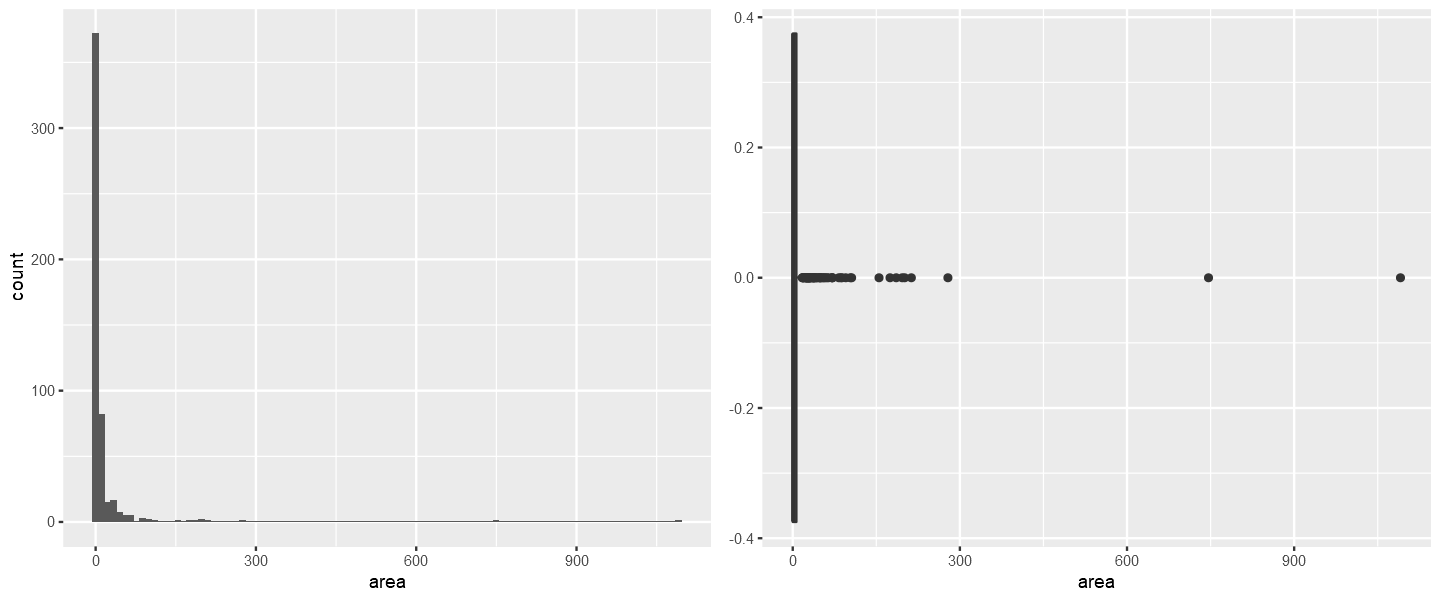

In [68]:
options(repr.plot.width=12, repr.plot.height=5)
plot1 <- ggplot(df_fires, aes(area)) + geom_histogram(bins = 100)
plot2 <- ggplot(df_fires, aes(area)) + geom_boxplot()
grid.arrange(plot1, plot2, nrow = 1)

This is an extremely skewed variable and most likely to make a prediction we will have to handle it accordingly. We plan to do a regression in the future and this might be a problem, because for the residuals to be normal the dependent variable cannot have a extremely skewed distribution (as this one). A possible first strategy is to apply the `logarithm` and see how the data will reshape. Important: As we saw many of the data points of area are equal to 0 - so we cannot pass the pure log, but instead we will apply the formula $y = (log_{10}x+1)$

In [66]:
df_fires$logarea <- log(df_fires$area+1)

Lets check the effect on the distribution of the area.

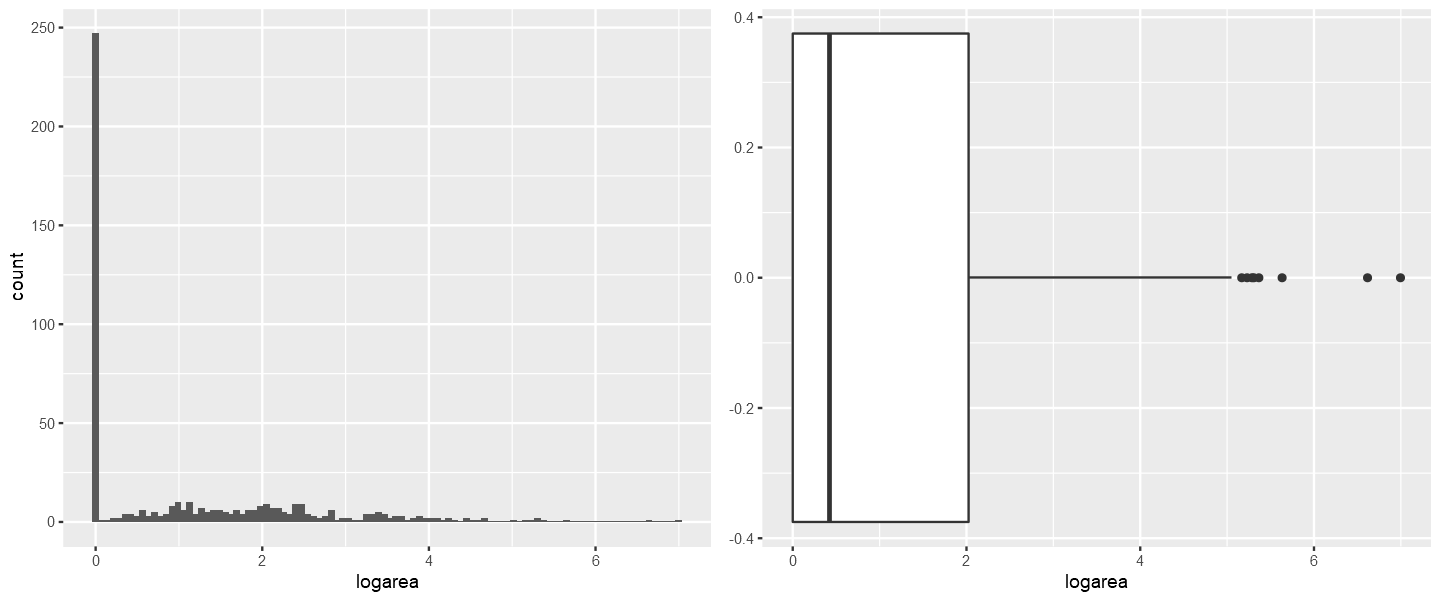

In [69]:
# options(repr.plot.width=12, repr.plot.height=5)
plot3 <- ggplot(df_fires, aes(logarea)) + geom_histogram(bins = 100)
plot4 <- ggplot(df_fires, aes(logarea)) + geom_boxplot()
grid.arrange(plot3, plot4, nrow = 1)

We can see a significant improve in the distribution of the data. Now lets build a table that will be used to explore with more details the numbers.

In [27]:
breaks = seq(range(df_fires$logarea)[1], range(df_fires$logarea)[2] + 2, by=1)
df_fires$size_area = cut(df_fires$logarea, breaks, right=FALSE)

In [29]:
df_fires %>%
  group_by(size_area) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

size_area,Total_Area,Count_Fires
<fct>,<dbl>,<int>
"[0,1)",50.43,299
"[1,2)",298.86,84
"[2,3)",762.69,74
"[3,4)",1220.69,37
"[4,5)",1068.16,14
"[5,6)",1404.10,7
"[6,7)",1837.12,2


### Spatial Analysis
The dataset contains spatial information representing the fires location. The X and Y variables represent the geographical locations in a map and can only be analysed together to make sense. The X axis ranges from 1 to 9 (integers) while the y axis from 2 to 9. Together, they form an area of 72 spaces. We will develop heatmaps in the folowing to identify areas that have been particular areas of focus of fires with respect to:
- The area affected.
- The number of fires.
- The median number of fires.
- The standar deviation of fires. 

In [57]:
# create a table 
df_spatial <- df_fires %>%
  group_by(X,Y) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n(),
            Median_Fire = median(area, na.rm = TRUE),
            SD_fire = sd(area, na.rm = TRUE),
            temp = sd(temp, na.rm = TRUE))

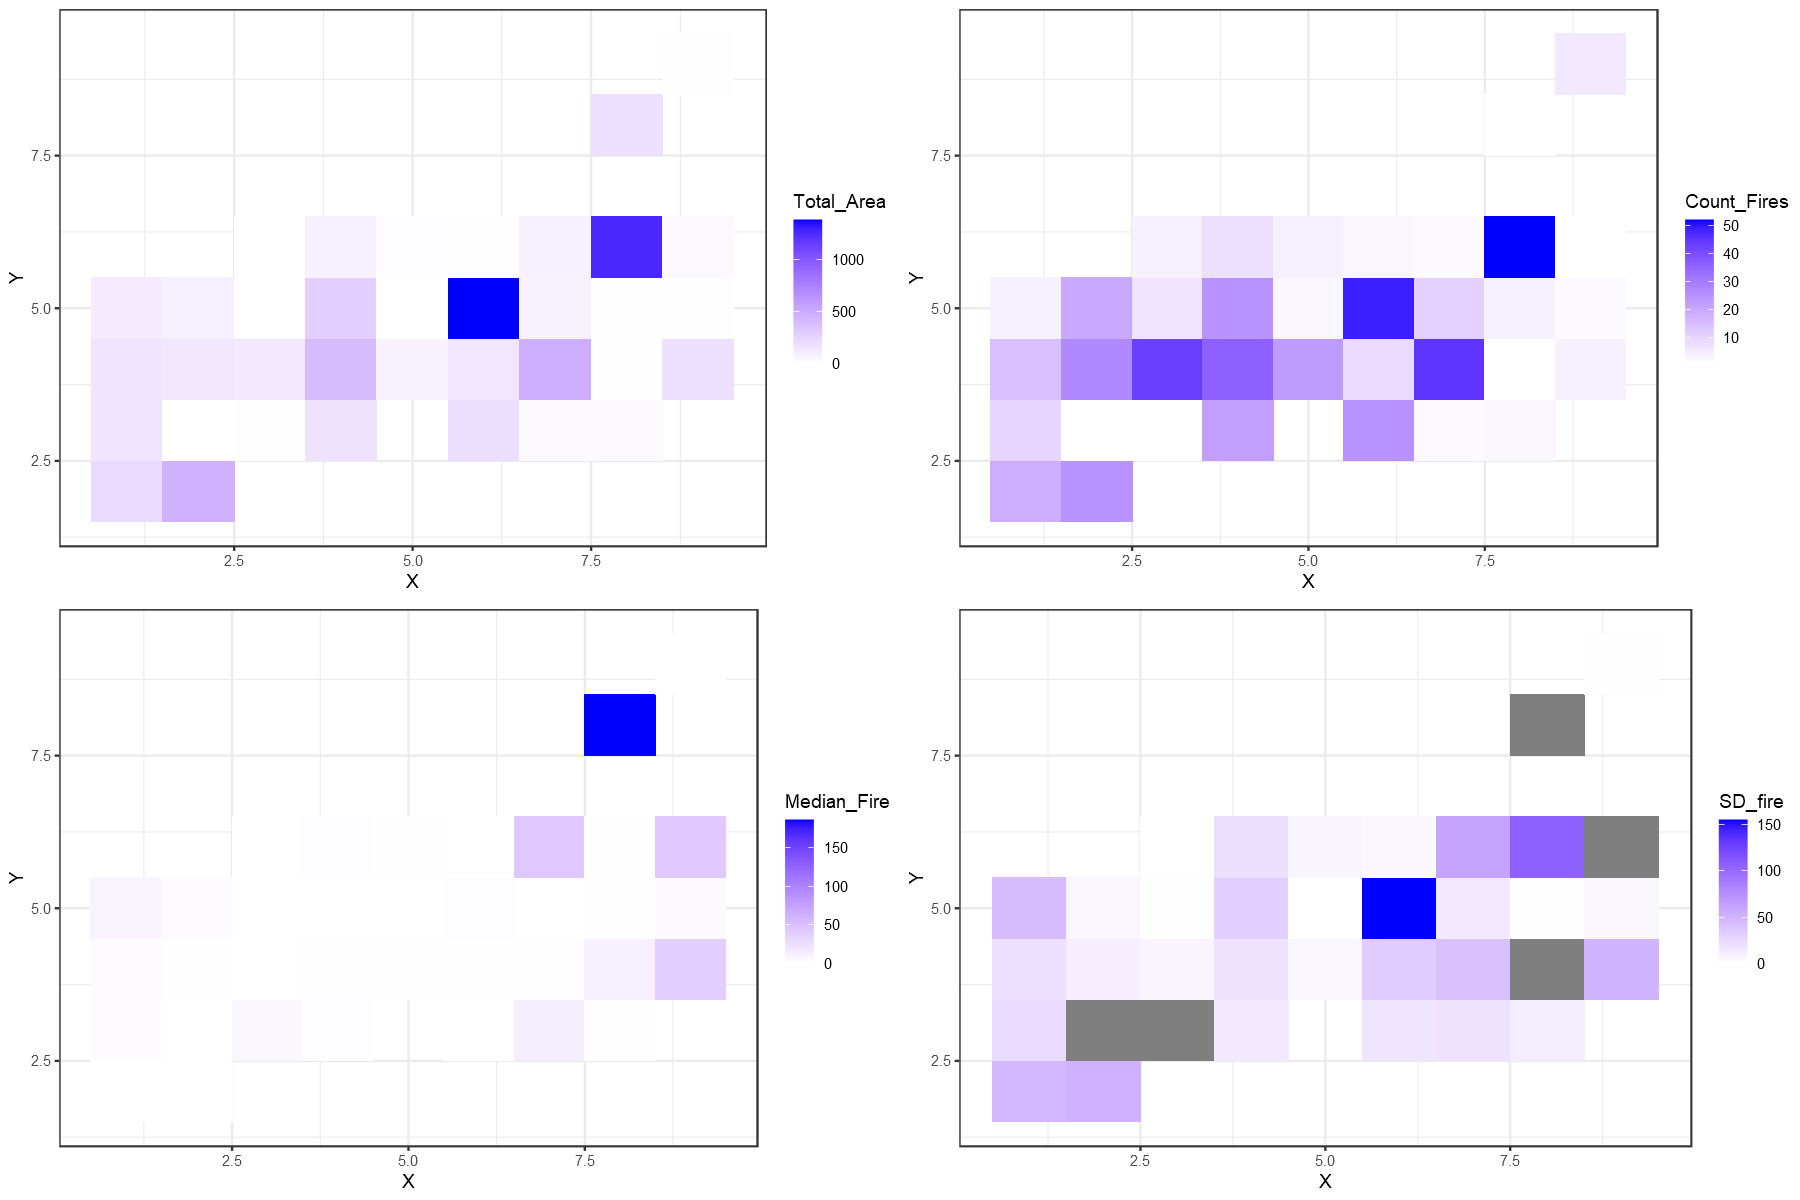

In [58]:
# options(repr.plot.width=15, repr.plot.height=10)
Total.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = Total_Area)) + geom_tile()+ theme_bw() + scale_fill_gradient(low="white", high="blue")
Count.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = Count_Fires)) + geom_tile() + theme_bw()+ scale_fill_gradient(low="white", high="blue")
Median.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = Median_Fire)) + geom_tile() + theme_bw()+ scale_fill_gradient(low="white", high="blue")
sd.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = SD_fire)) + geom_tile() + theme_bw()+ scale_fill_gradient(low="white", high="blue")
grid.arrange(Total.heatmap, Count.heatmap, Median.heatmap, sd.heatmap,ncol=2, nrow = 2)

## A first look at correlations

In [71]:
options(repr.plot.width=15, repr.plot.height=10)
ggpairs(df_rfires[,c(1,2,seq(5,13))])

ERROR: Error in ggpairs(df_rfires[, c(1, 2, seq(5, 13))]): could not find function "ggpairs"


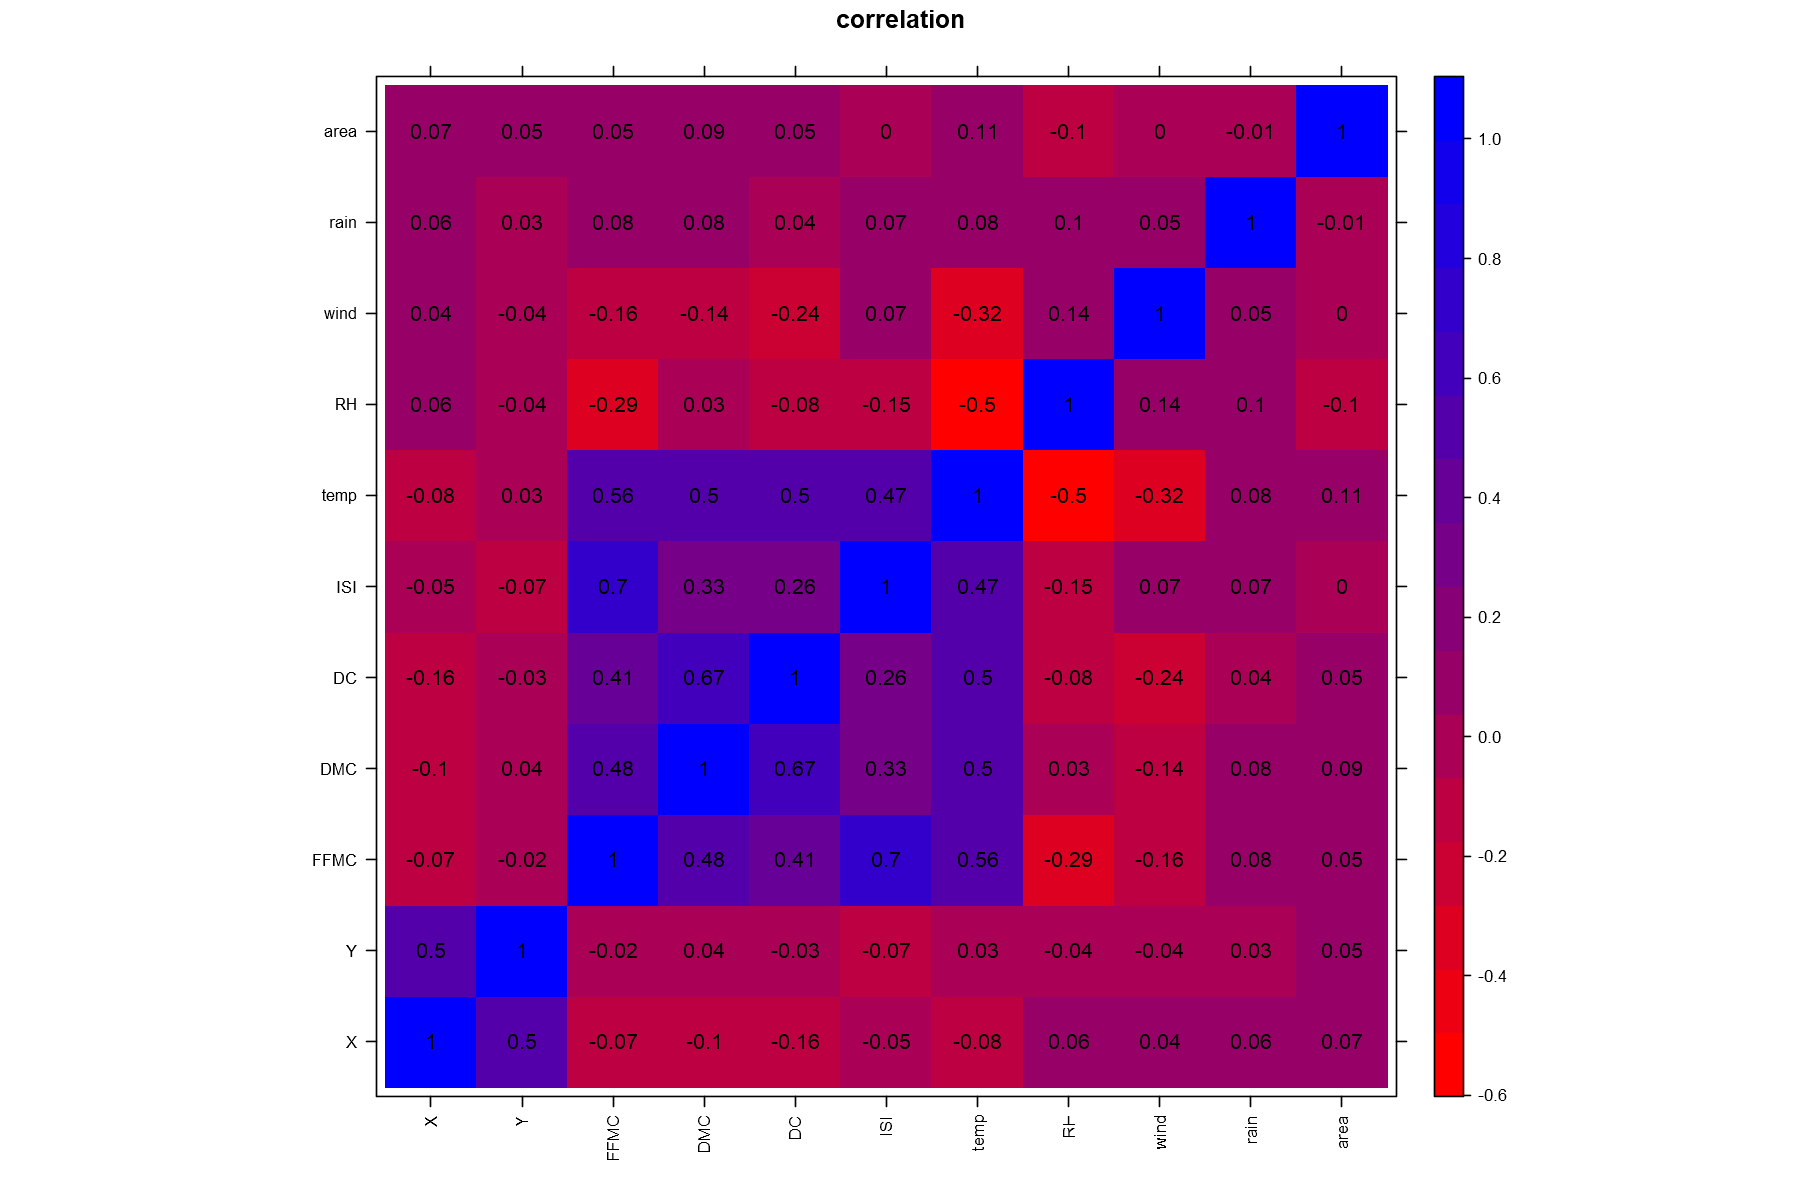

In [12]:
#Define you own panel
myPanel <- function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x, y, round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))
#Plot the correlation matrix.
levelplot(cor(df_rfires[,c(1,2,seq(5,13))]), col.regions = cols(100), main = "correlation", xlab = NULL, ylab = NULL, 
          scales = list(x = list(rot = 90)), panel = myPanel)

### Exploring seasonality.

By logic, we discharge the possibility that the day of the week may provoce a fire.  Firstly, lets create a new column called season.

In [23]:
library(dplyr)

In [24]:
df_rfires$season <- ifelse(df_rfires$month == "dec" | df_rfires$month == "jan" | df_rfires$month == "feb",'summer', 
                          ifelse(df_rfires$month == "mar" | df_rfires$month == "apr" | df_rfires$month == "may","autumn",
                                 ifelse(df_rfires$month == "jun" | df_rfires$month == "jul" | df_rfires$month =="aug", "winter",
                                        ifelse(df_rfires$month == "sep" | df_rfires$month == "oct" | df_rfires$month =='nov', "spring", 'NA'))))

In [25]:
df_rfires %>%
  group_by(season) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n())

season,Total_Area,Count_Fires
<chr>,<dbl>,<int>
autumn,353.76,24
spring,3185.70,102
summer,245.47,19
winter,2857.12,125


### starting the regression

In [26]:
library(ISLR)
library(ggplot2)
library(GGally)
library(gridExtra)
library(cowplot)

In [37]:
head(df_rfires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,"[0.09,50.1)",winter,-1.0216512
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,"[0.09,50.1)",spring,-0.8439701
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,"[0.09,50.1)",spring,-0.7550226
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55,"[0.09,50.1)",winter,-0.5978370
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61,"[0.09,50.1)",winter,-0.4942963
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71,"[0.09,50.1)",winter,-0.3424903


### Regression against quantitative variables 

In [63]:
mod <- lm(logarea ~ ., data=df_rfires[c(seq(1,12),14,15,16)])

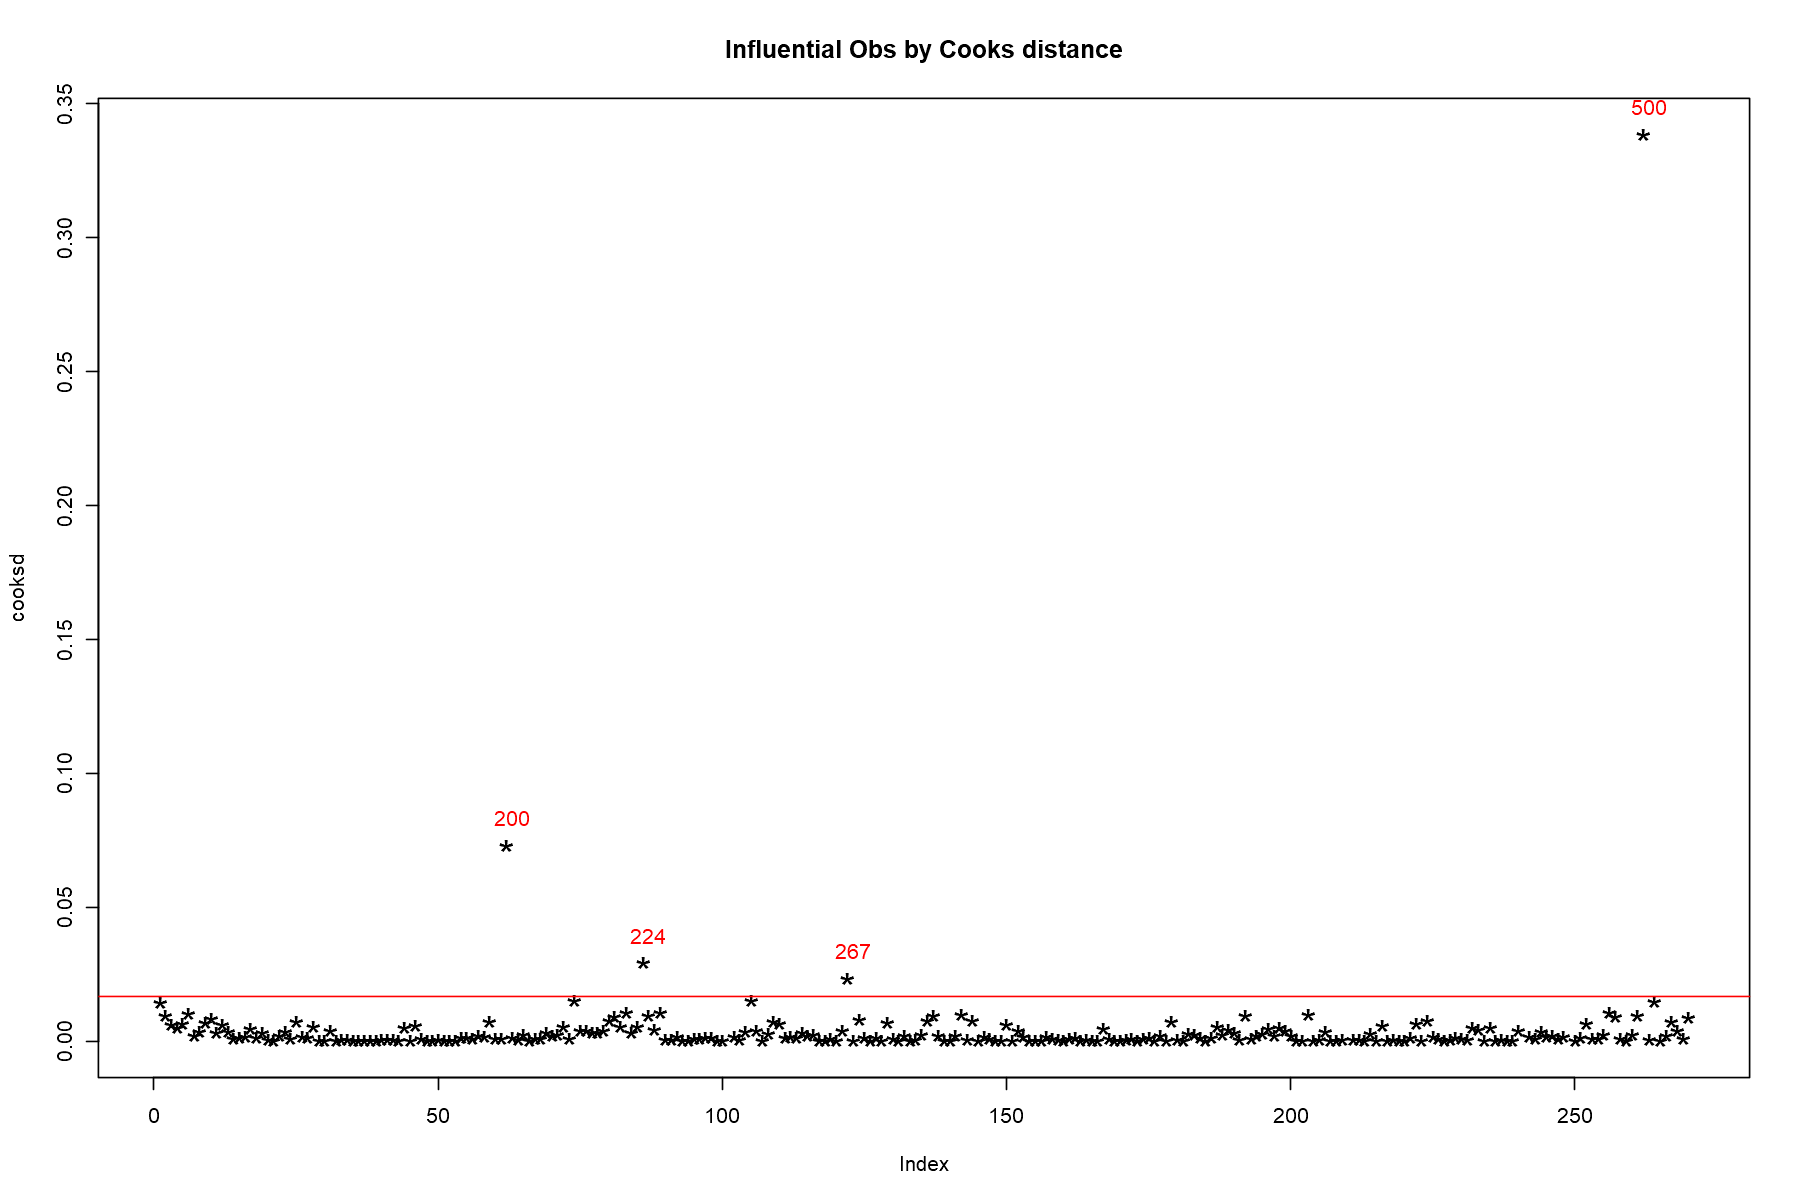

In [61]:
cooksd <- cooks.distance(mod)
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd+0.01, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [53]:
influential = which(cooksd>4*mean(cooksd, na.rm=T))
df_rfires[influential, ]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
200,2,4,sep,mon,63.5,70.8,665.3,0.8,22.6,38,3.6,0.0,11.32,"[0.09,50.1)",spring,2.426571
224,2,2,jul,fri,88.3,150.3,309.9,6.8,13.4,79,3.6,0.0,37.02,"[0.09,50.1)",winter,3.611458
267,6,5,aug,tue,94.3,131.7,607.1,22.7,19.4,55,4.0,0.0,0.17,"[0.09,50.1)",winter,-1.771957
500,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,"[0.09,50.1)",winter,2.381396


For now, let's remove outliers.

In [68]:
new_df_rfires = df_rfires[-influential, ]

In [69]:
influential

200 224 267 500 
 62  86 122 262

### Model Build

In [71]:
new_data <- rbind(new_df_rfires[which(df_fires$area == 0),],new_df_rfires)
new_data$b_area <- ifelse(new_data$area == 0, 0, 1)

ERROR: Error in rbind(deparse.level, ...): numbers of columns of arguments do not match


In [74]:
head(df_rfires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_area,season,logarea
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>
139,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0,0.36,"[0.09,50.1)",winter,-1.0216512
140,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0,0.43,"[0.09,50.1)",spring,-0.8439701
141,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0,0.47,"[0.09,50.1)",spring,-0.7550226
142,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0,0.55,"[0.09,50.1)",winter,-0.5978370
143,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0,0.61,"[0.09,50.1)",winter,-0.4942963
144,1,2,jul,sat,90.0,51.3,296.3,8.7,16.6,53,5.4,0,0.71,"[0.09,50.1)",winter,-0.3424903


In [73]:
head(df_fires)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0
